In [1]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/MonU/MidTerm/netflix_titles.csv')

except ModuleNotFoundError:
    try:
        df = pd.read_csv('netflix_titles.csv')
    except FileNotFoundError:
        print("Check csv Location")



# Check for Missing and Duplicated Data

Number of missing values in director is 2634
Number of missing values in cast is 825
Number of missing values in country is 831
Number of missing values in date_added is 10
Number of missing values in rating is 4
Number of missing values in duration is 3
Total Number of missing values is 4307


0 rows are duplicated




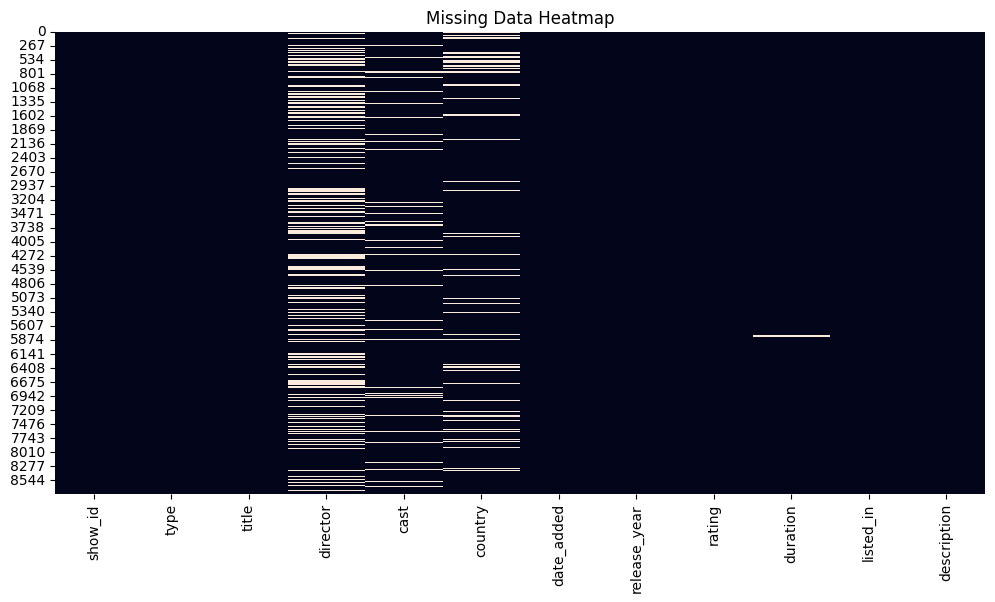

In [3]:
#print(df.describe())
def check_missing(df, heat_map = True, dup = True):
  for i in df.columns:
    if df[i].isnull().sum() != 0:
      print(f"Number of missing values in {i} is {df[i].isnull().sum().sum()}")
  print(f"Total Number of missing values is {df.isnull().sum().sum()}")

  if dup == True:
    print('\n')
    print(f"{df.duplicated().sum()} rows are duplicated")
    print('\n')

  if heat_map == True:
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title('Missing Data Heatmap')
    plt.show()

check_missing(df)

# Handling Missing Data

In [4]:
# Replace missing values
#df['director'].fillna('Not Specified', inplace=True)
#df['director'] = df['director'].fillna('Not Specified')


#create a new copy and update?
for i in range(len(df.columns)):
    #print(df.columns[i])
    if df.columns[i] == 'date_added':
        df[df.columns[i]] =  df[df.columns[i]].fillna('0')
    else:
        df[df.columns[i]] =  df[df.columns[i]].fillna('Not Specified')

# Drop rows with missing 'date_added'
#df.fillna(subset=['date_added'], inplace=True)
#df['year_added'] = df['date_added'].dt.year.fillna(0).astype(int)

check_missing(df, False, False)



Total Number of missing values is 0


In [5]:
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Not Specified,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,Not Specified,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Not Specified,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,Not Specified,Not Specified,Not Specified,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Not Specified,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# Data Cleaning and Data Prep

In [6]:
print(f"There are {len(df.columns)} columns in the dataset")
print(f"There are {len(df)} rows in the dataset")
print(df.dtypes)

There are 12 columns in the dataset
There are 8807 rows in the dataset
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [7]:
# Date Formatting
# Step 1: Strip leading/trailing spaces in the date column
try:
  df['date_added'] = df['date_added'].str.strip()
except AttributeError:
  pass

# Step 2: Convert to datetime with the desired format
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')
df['month_year'] = df['date_added'].dt.to_period('M')
df['month_added'] = df['date_added'].dt.strftime('%B')
df['day_added'] = df['date_added'].dt.strftime('%A')
#check_missing(df, False, False)
#df['year_added'] = df['date_added'].dt.year.astype(int)
df['year_added'] = df['date_added'].dt.year.fillna(0).astype(int)
#Confirming the datatype change
date_check = ['date_added', 'release_year', 'month_year', 'month_added', 'day_added', 'year_added']
for i in range(len(date_check)):
  print(f"{date_check[i]} \t {df[date_check[i]].dtypes}")


date_added 	 datetime64[ns]
release_year 	 int64
month_year 	 period[M]
month_added 	 object
day_added 	 object
year_added 	 int64


In [8]:
# List of columns to analyze
qualitative_data = ['type', 'director', 'cast', 'country', 'release_year', 'rating', 'duration', 'listed_in',
                    'month_added', 'day_added', 'year_added']

# Columns that need splitting and exploding
columns_to_split = ['director', 'cast', 'country', 'listed_in']

# Initialize dictionaries
qualitative_data_df = {}
qualitative_data_counts = {}

# Iterate over each column
for col in qualitative_data:
    # Convert to string to avoid issues with NaN or other types
    df[col] = df[col].astype(str)

    # Check if the column needs to be split and exploded
    if col in columns_to_split:
        # Split the string into a list
        df[col] = df[col].str.split(', ')
        # Explode the DataFrame to have one value per row
        temp_df = df.explode(col)
    else:
        # No need to split; use the original DataFrame
        temp_df = df.copy()

    # Store the exploded or original DataFrame in the dictionary
    qualitative_data_df[col] = temp_df

    # Get the value counts for the column
    
    qualitative_data_counts[col] = temp_df[col].value_counts().head(20)

# Now, qualitative_data_df and qualitative_data_counts are dictionaries
# You can access them using the column names


# Print the results
print(qualitative_data_counts['cast'])

cast
Not Specified        825
Anupam Kher           43
Shah Rukh Khan        35
Julie Tejwani         33
Naseeruddin Shah      32
Takahiro Sakurai      32
Rupa Bhimani          31
Om Puri               30
Akshay Kumar          30
Yuki Kaji             29
Amitabh Bachchan      28
Paresh Rawal          28
Boman Irani           27
Rajesh Kava           26
Vincent Tong          26
Kareena Kapoor        25
Andrea Libman         25
John Cleese           24
Samuel L. Jackson     24
Jigna Bhardwaj        23
Name: count, dtype: int64


# Descriptive Statistics

In [9]:
df.describe()


,date_added
count,8797
mean,2019-05-17 05:59:08.436967168
min,2008-01-01 00:00:00
25%,2018-04-06 00:00:00
50%,2019-07-02 00:00:00
75%,2020-08-19 00:00:00
max,2021-09-25 00:00:00


# Distribution

In [10]:
# Bar chart
chat_dict = {}

for i, key in enumerate(qualitative_data_counts):
    # For each category, add an entry to the dictionary
    #print(len(qualitative_data_counts[i]))
    if key == 'rating':
        chat_dict[key] = [f'Top {len(qualitative_data_counts[key].head(13))} {key.capitalize()}', qualitative_data_counts[key].head(13)]
    else:
        chat_dict[key] = [f'Top {len(qualitative_data_counts[key])} {key.capitalize()}', qualitative_data_counts[key]]

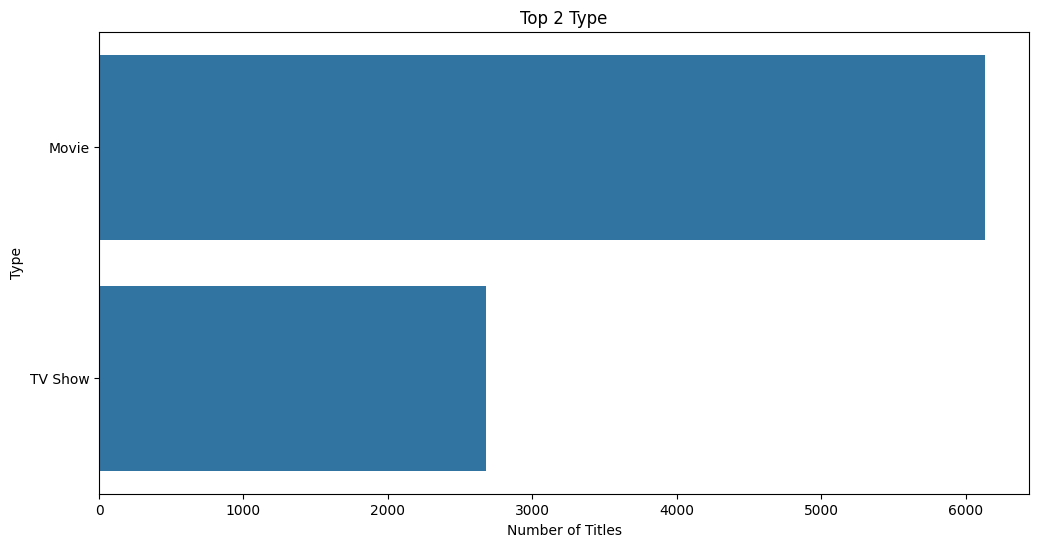

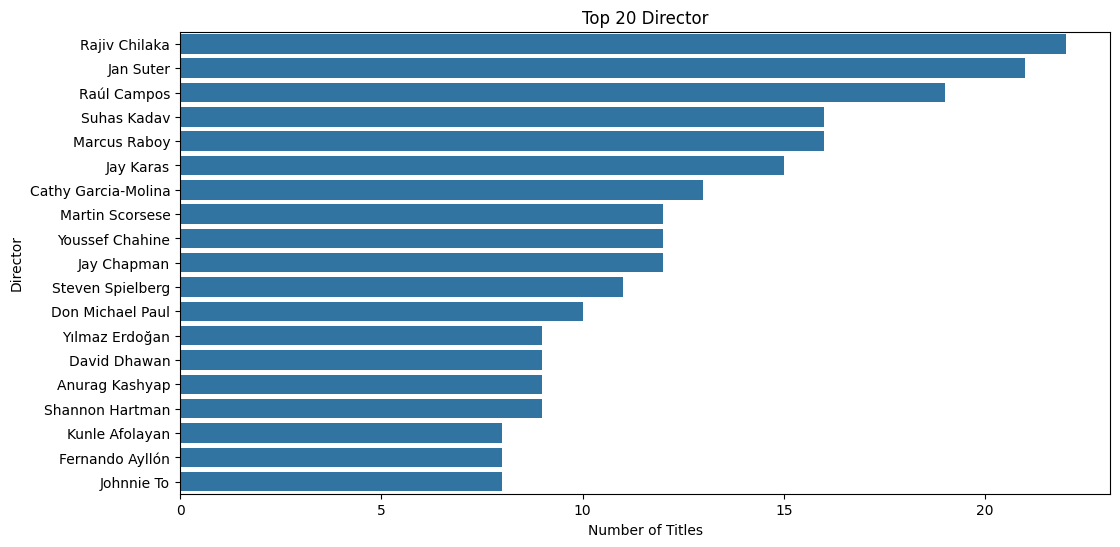

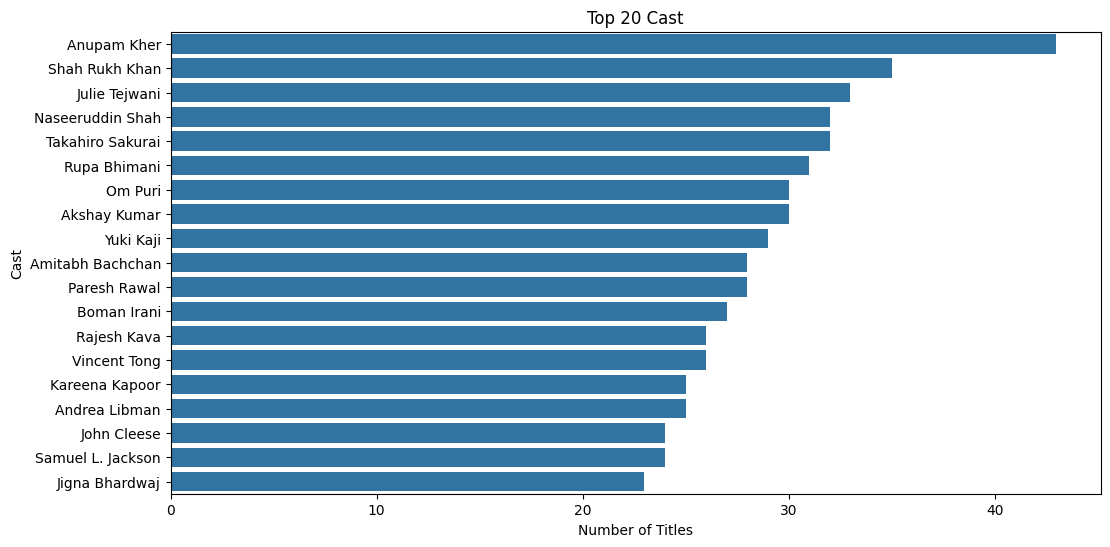

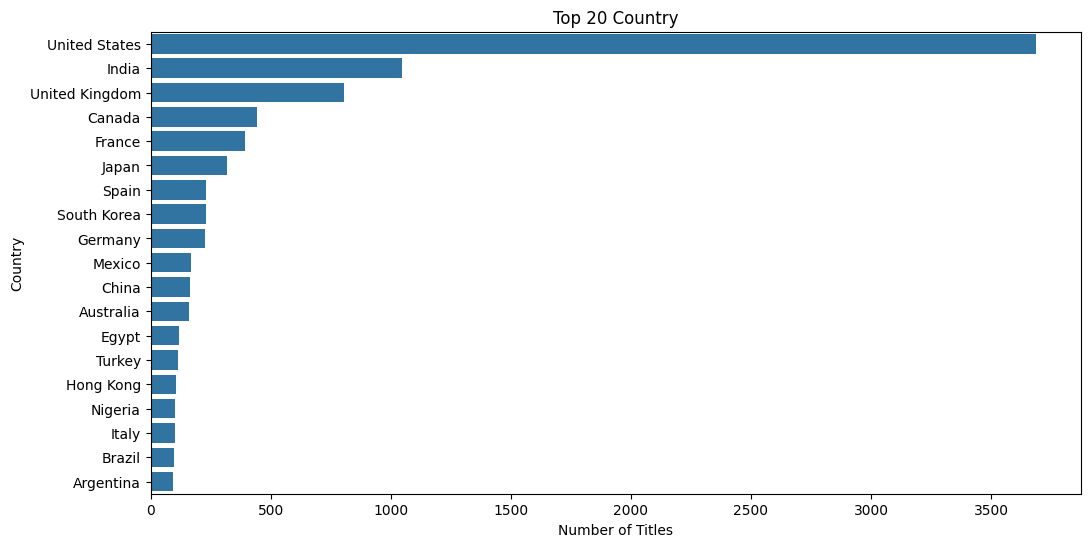

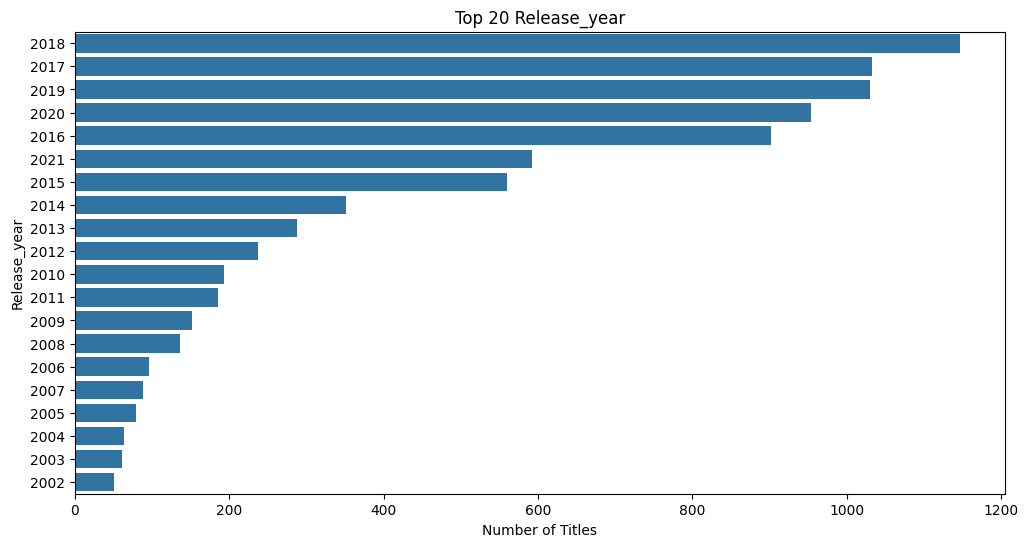

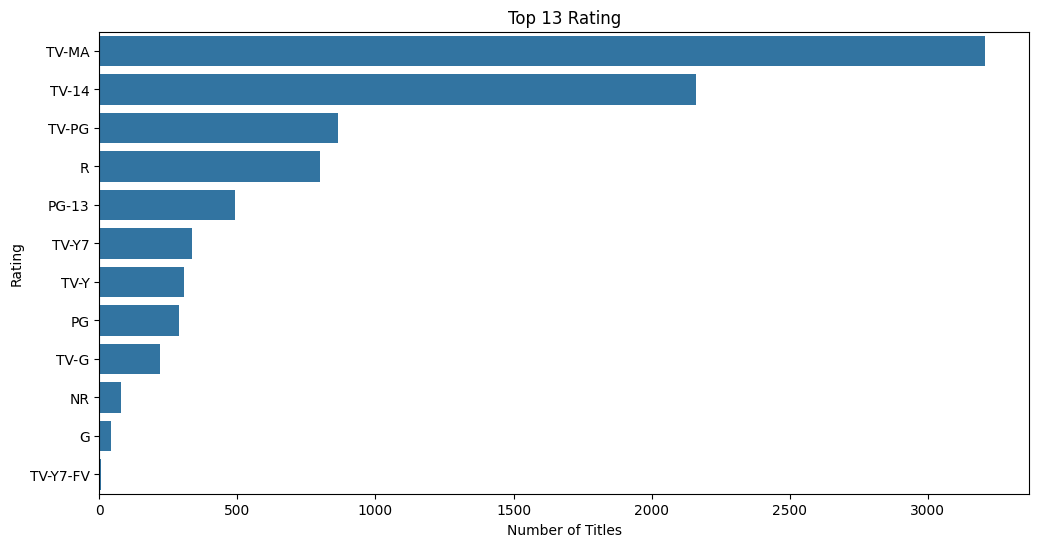

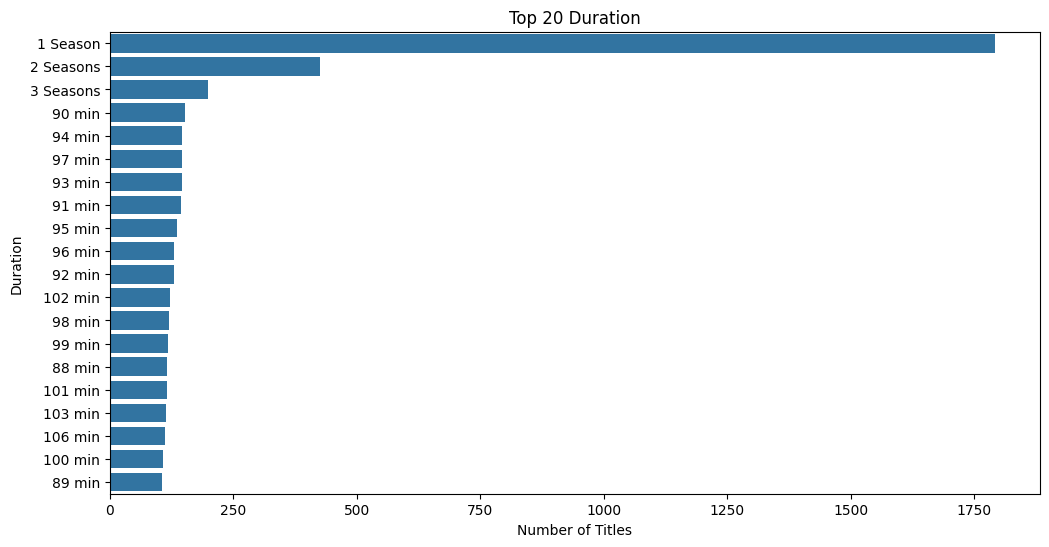

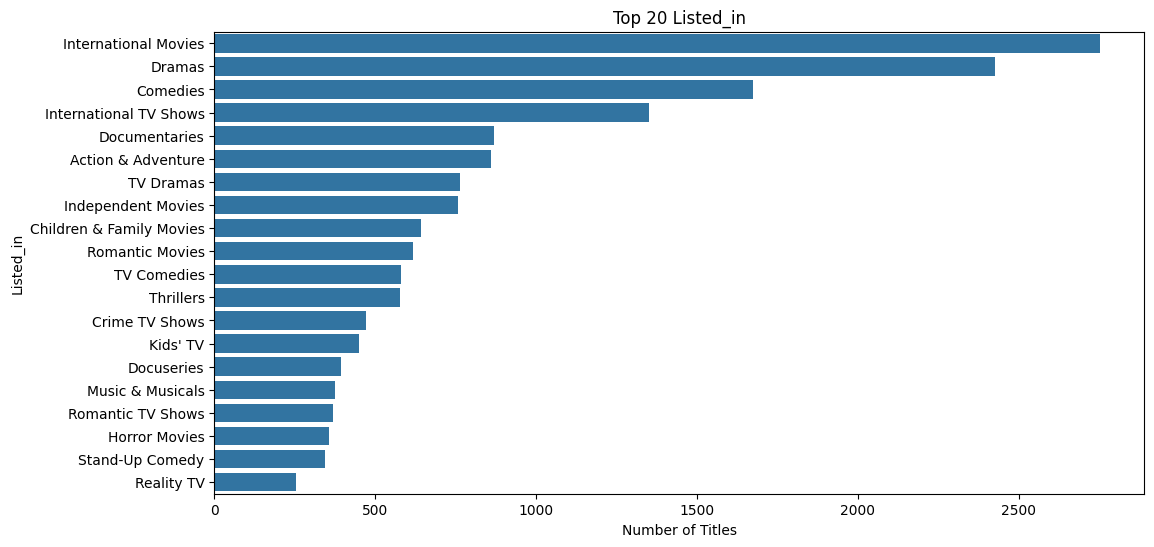

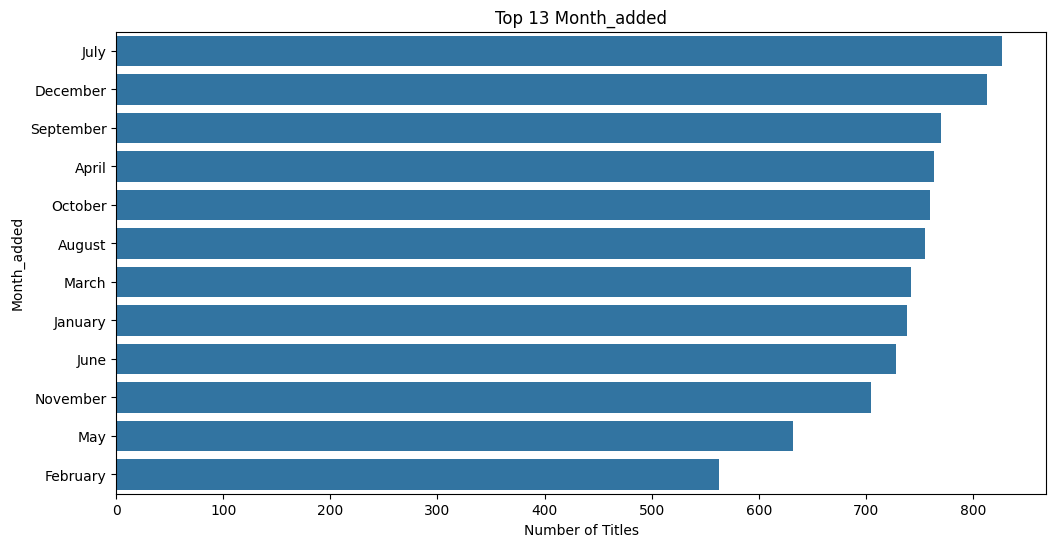

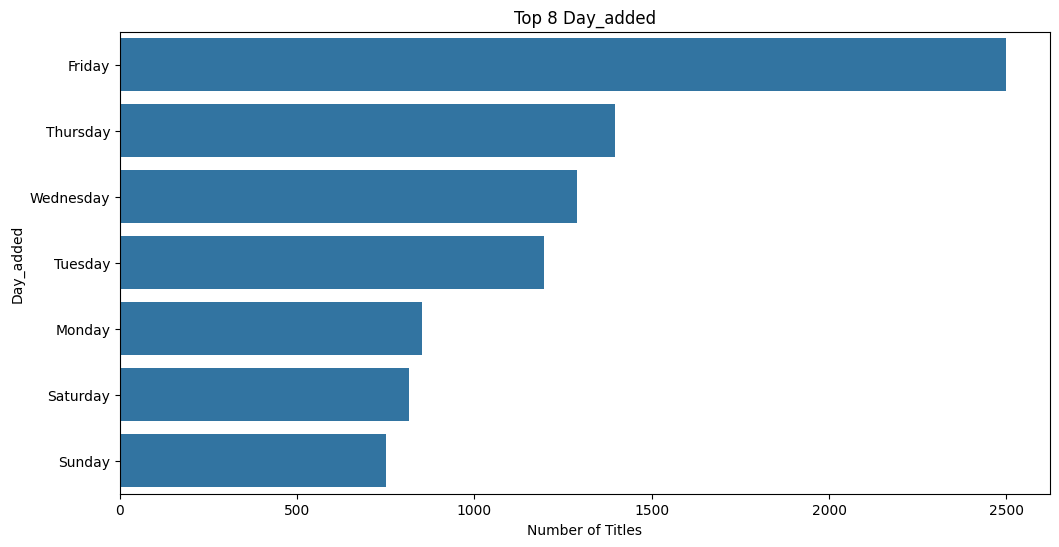

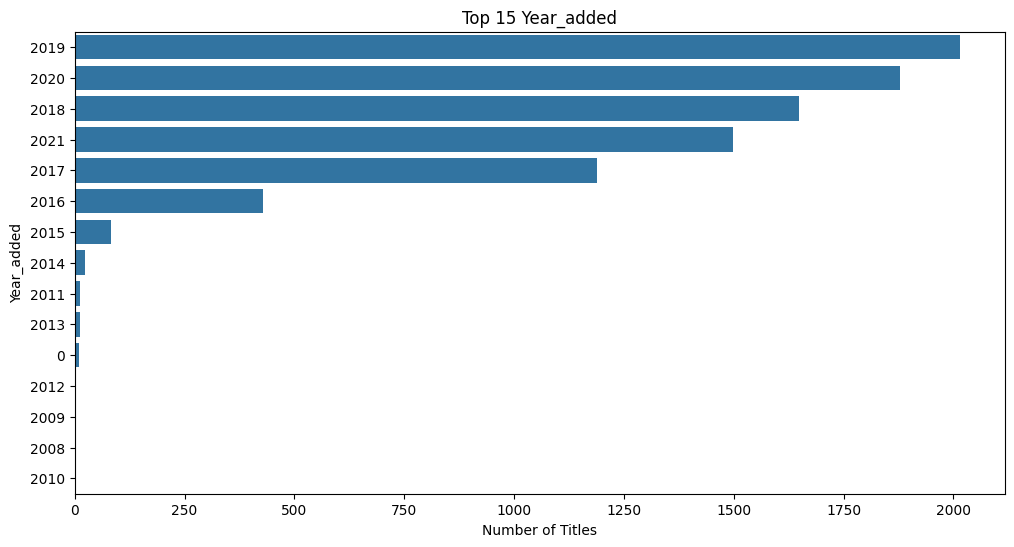

In [11]:

for key, value in chat_dict.items():
  #filtered_values = value[1][value[1].index != ('Not Specified' or 'Unknown' or 'nan')]
  filtered_values = value[1][~value[1].index.isin(['Not Specified', 'Unknown', 'nan']) & value[1].notna()]
  plt.figure(figsize=(12,6))
  sns.barplot(x=filtered_values.values, y=filtered_values.index)
  plt.title(value[0])
  plt.xlabel('Number of Titles')
  plt.ylabel(key.capitalize())
  plt.show()


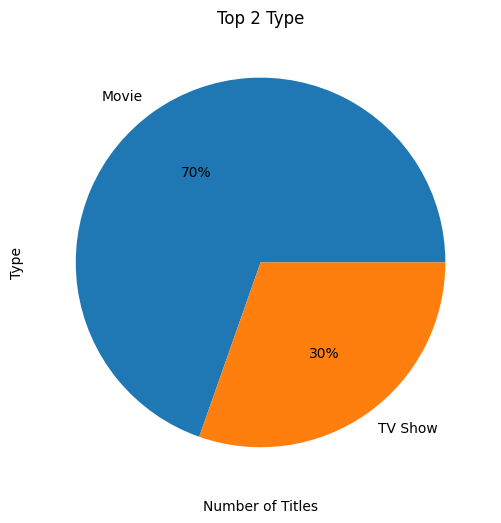

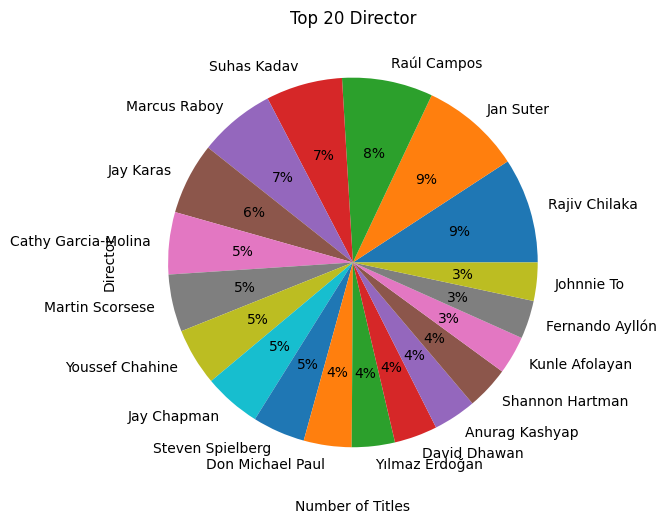

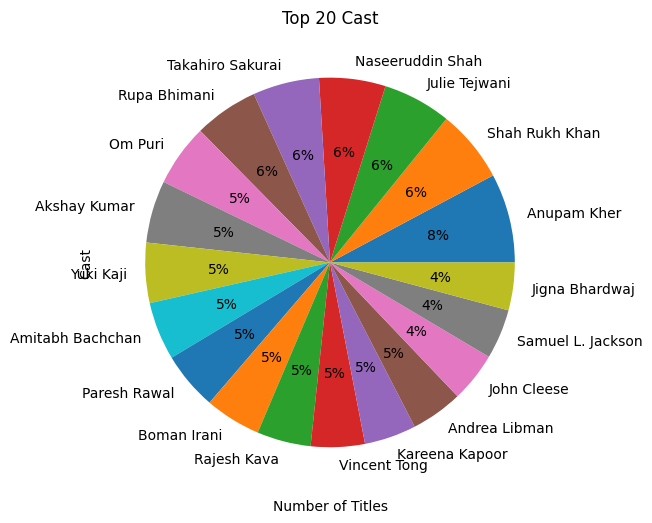

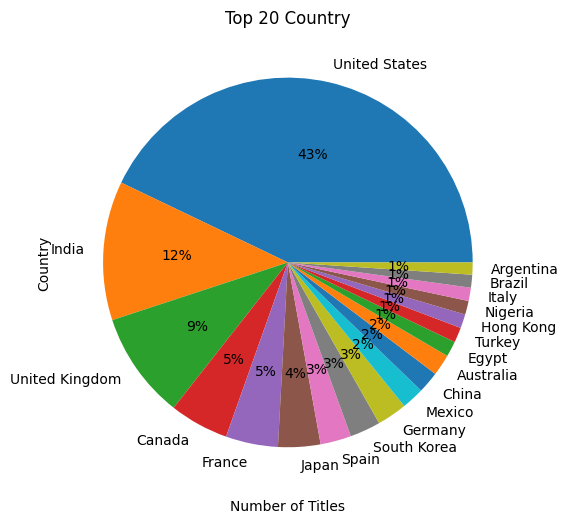

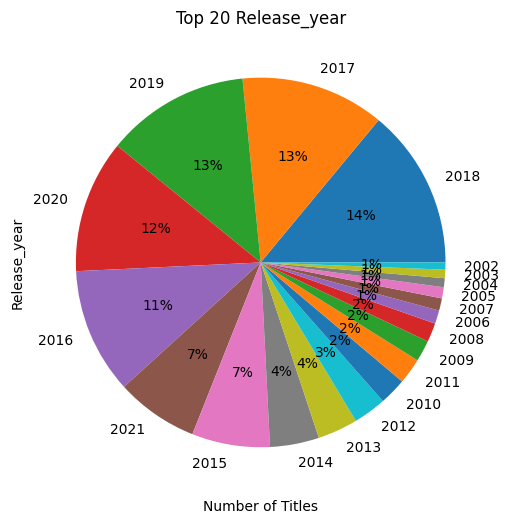

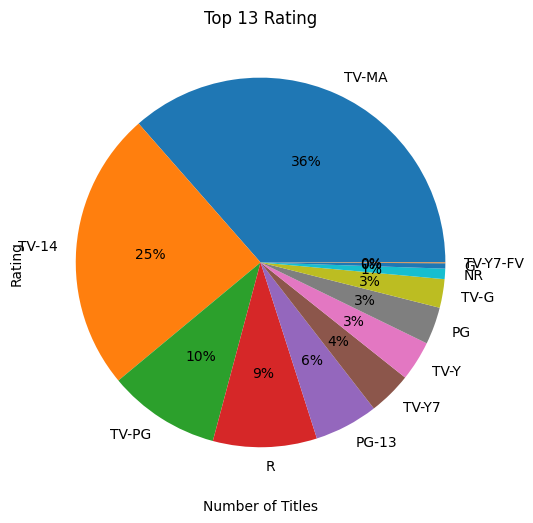

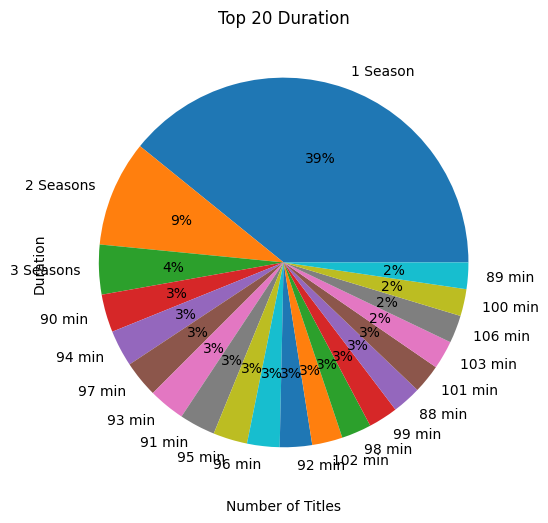

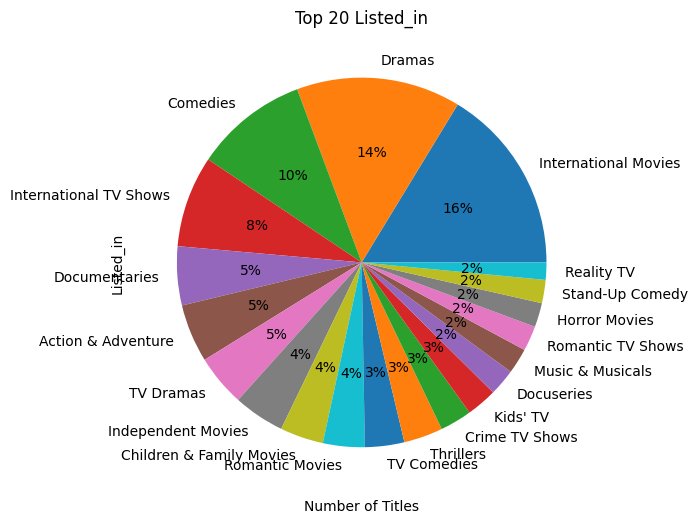

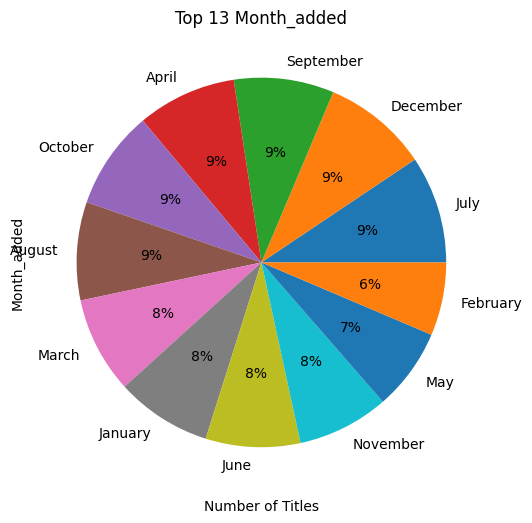

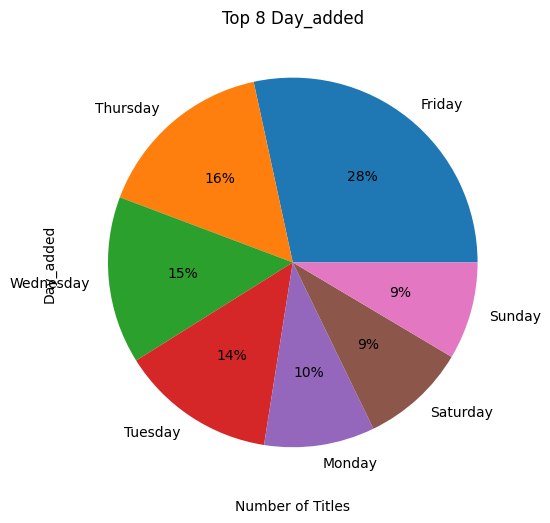

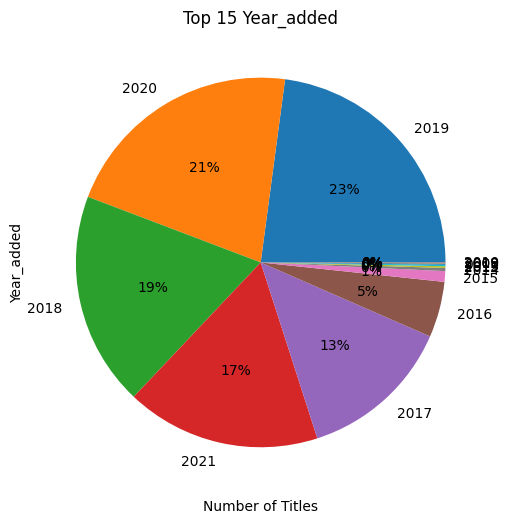

In [12]:

for i,(key, value) in enumerate(chat_dict.items()):
  #filtered_values = value[1][value[1].index != ('Not Specified' or 'Unknown')]
  filtered_values = value[1][~value[1].index.isin(['Not Specified', 'Unknown', 'nan']) & value[1].notna()]
  plt.figure(figsize=(12,6))
  #plt.pie(x=filtered_values.values, y=filtered_values.index)
  plt.pie(filtered_values.values, labels = filtered_values.index,  autopct='%.0f%%')
  plt.title(value[0])
  plt.xlabel('Number of Titles')
  plt.ylabel(key.capitalize())
  plt.show()


# Line Plots

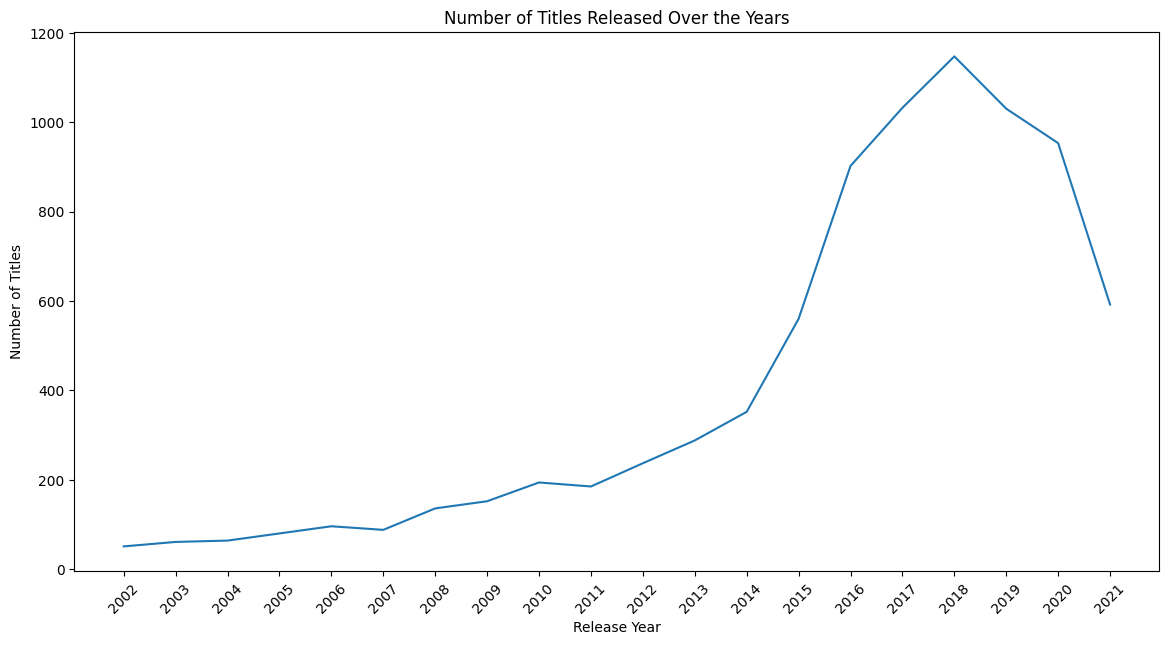

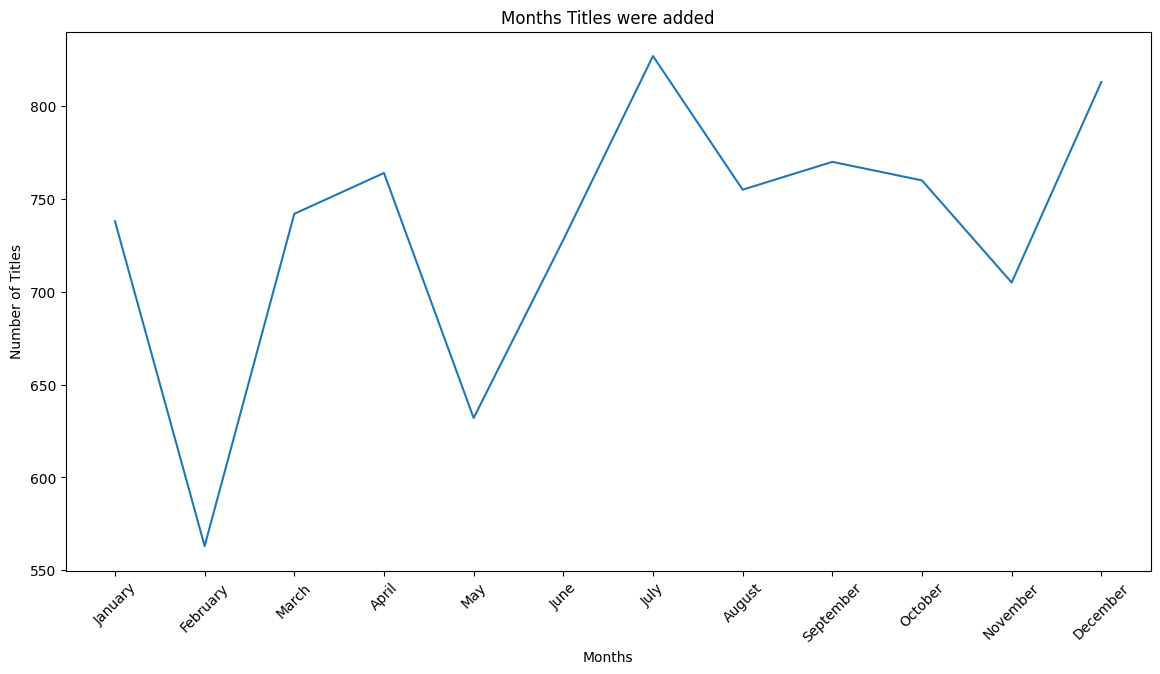

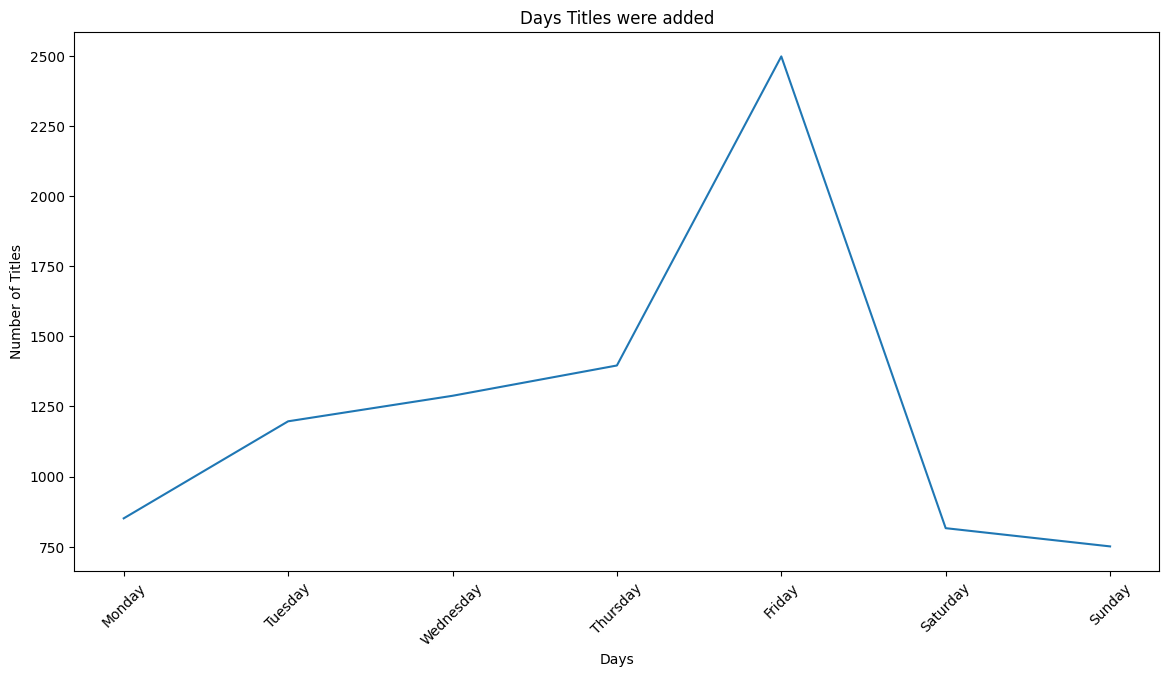

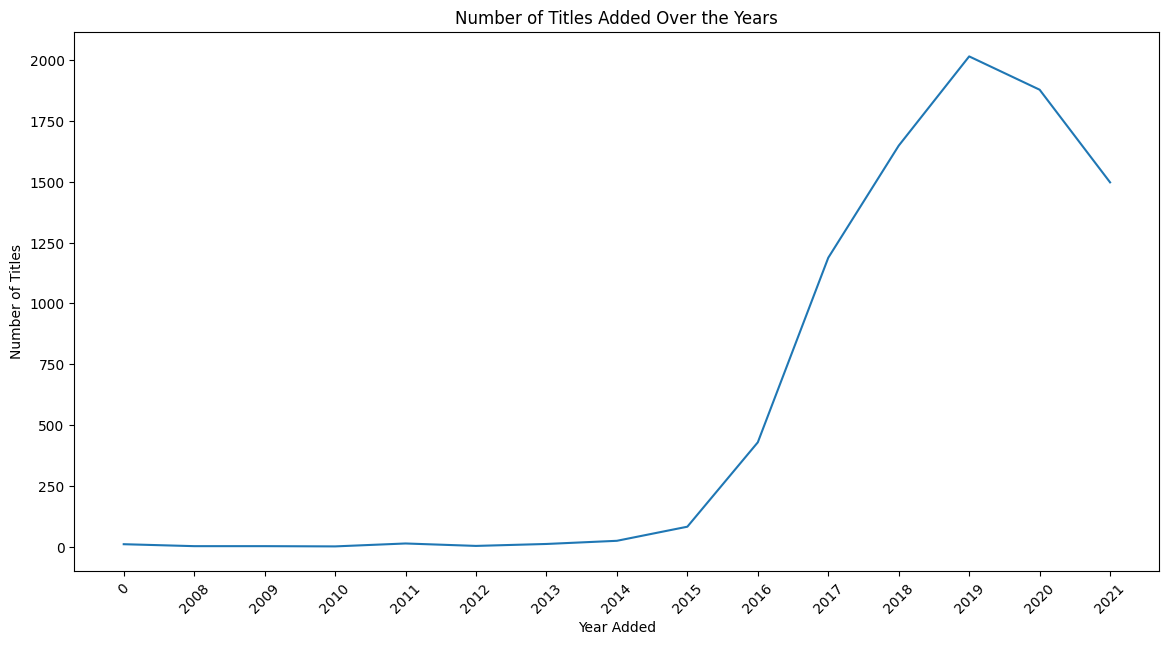

In [13]:
# Correct order for months and days
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Dictionary for plotting
title_xlabel_ylabel_chat = {
    'release_year': ['Number of Titles Released Over the Years', 'Release Year', 'Number of Titles'],
    'month_added': ['Months Titles were added', 'Months', 'Number of Titles'],
    'day_added': ['Days Titles were added', 'Days', 'Number of Titles'],
    'year_added': ['Number of Titles Added Over the Years', 'Year Added', 'Number of Titles']
}

for key, values in title_xlabel_ylabel_chat.items():
    # Sort index for each key
    titles_per_year = qualitative_data_counts[key].sort_index()

    # Apply specific sorting for months or days if needed
    if key == 'month_added':
        titles_per_year.index = pd.Categorical(titles_per_year.index, categories=months_order, ordered=True)
        titles_per_year = titles_per_year.sort_index()  # Sort by the correct month order

    elif key == 'day_added':
        titles_per_year.index = pd.Categorical(titles_per_year.index, categories=days_order, ordered=True)
        titles_per_year = titles_per_year.sort_index()  # Sort by the correct day order

    # Plot the line chart
    plt.figure(figsize=(14,7))
    sns.lineplot(x=titles_per_year.index, y=titles_per_year.values)
    plt.title(values[0])
    plt.xlabel(values[1])
    plt.ylabel(values[2])
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
    plt.show()


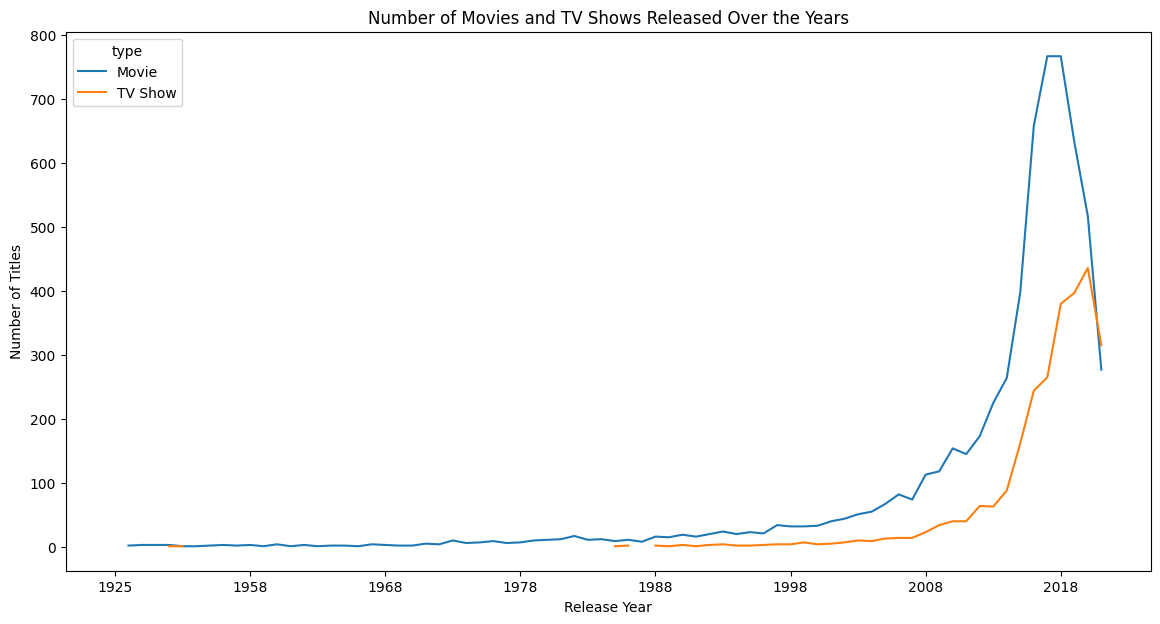

In [14]:
# Titles per year by type
titles_year_type = df.groupby(['release_year', 'type']).size().unstack()

# Line plot
titles_year_type.plot(figsize=(14,7))
plt.title('Number of Movies and TV Shows Released Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.show()


Skipping column 'director' because it contains lists.
Skipping column 'cast' because it contains lists.
Skipping column 'country' because it contains lists.
Skipping column 'listed_in' because it contains lists.


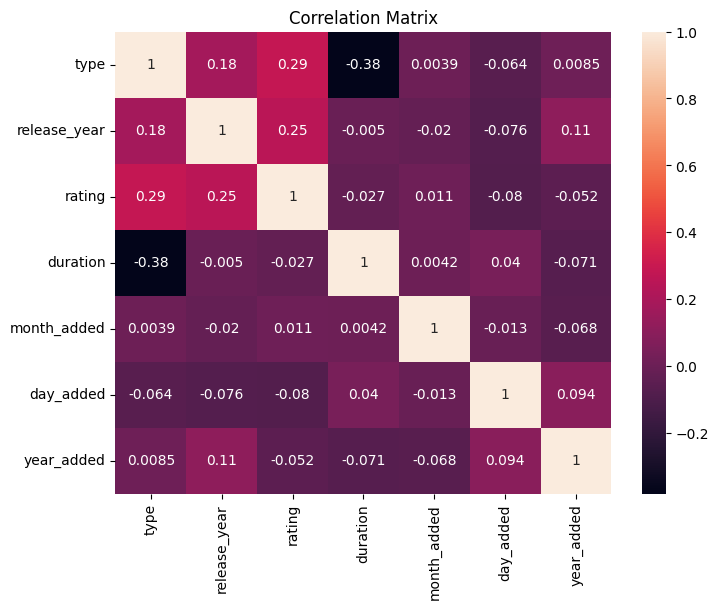

In [15]:
# Encoding 'type' and 'rating'

#qualitative_data_ = ['type', 'director', 'cast', 'country', 'release_year', 'rating', 'duration', 'listed_in', 'month_added', 'day_added', 'year_added']

df_encoded = df.copy()

qualitative_data_1 = []

for i in range (len(qualitative_data)):
  #print(i)
  #if type(df_encoded[qualitative_data[i]]) == 'list':
  if df_encoded[qualitative_data[i]].apply(lambda x: isinstance(x, list)).any():
    print(f"Skipping column '{qualitative_data[i]}' because it contains lists.")
    #continue  # Skip to the next iteration
  else:
    df_encoded[qualitative_data[i]] = df_encoded[qualitative_data[i]].astype('category').cat.codes
    qualitative_data_1.append(qualitative_data[i])


# Correlation matrix
#corr_matrix = df_encoded[['type_encoded', 'rating_encoded', 'release_year']].corr()
corr_matrix = df_encoded[qualitative_data_1].corr()
#print(corr_matrix)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()


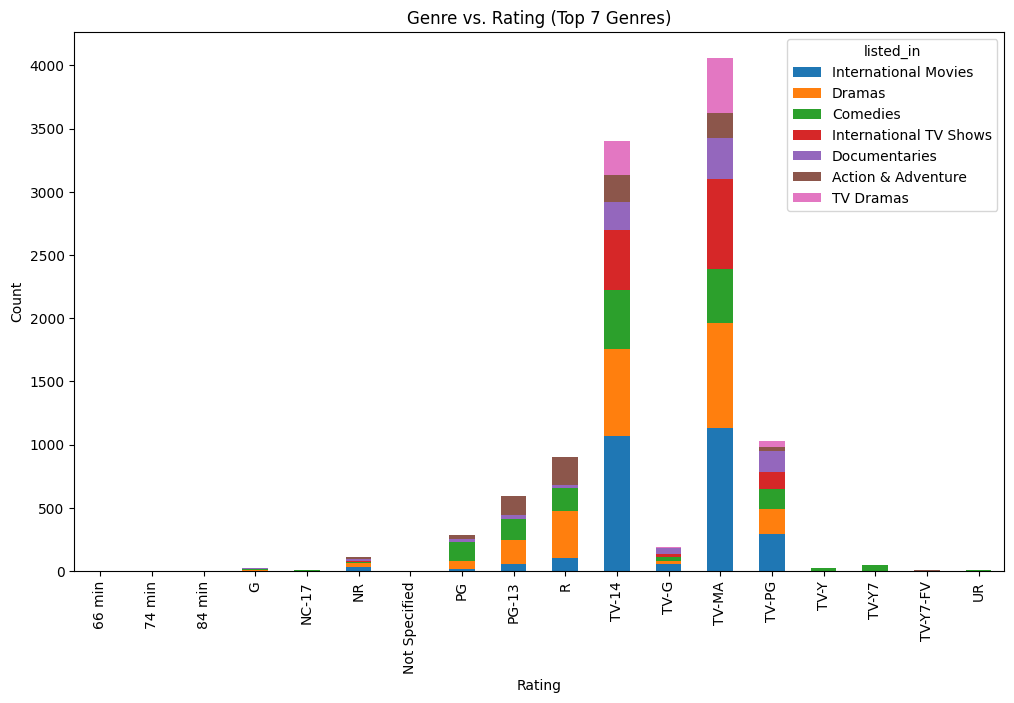

In [16]:
# Since genres are multiple per title, explode the dataframe
genre_rating_df = df.explode('listed_in')

# Cross-tabulation
genre_rating_ct = pd.crosstab(genre_rating_df['rating'], genre_rating_df['listed_in'])
genre_counts = genre_rating_df['listed_in'].value_counts().head(10)
# Select top genres
top_genres = genre_counts.head(7).index
genre_rating_ct = genre_rating_ct[top_genres]

# Stacked bar chart
genre_rating_ct.plot(kind='bar', stacked=True, figsize=(12,7))
plt.title('Genre vs. Rating (Top 7 Genres)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


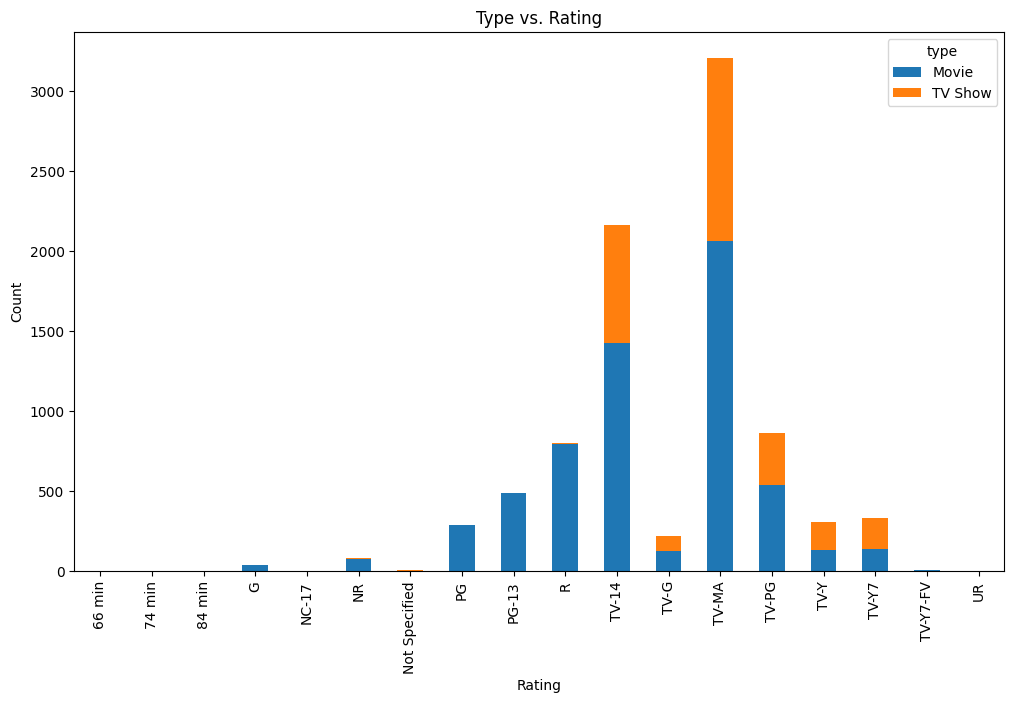

In [17]:
# Cross-tabulation
type_rating_ct = pd.crosstab(df['rating'], df['type'])

# Stacked bar chart
type_rating_ct.plot(kind='bar', stacked=True, figsize=(12,7))
plt.title('Type vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


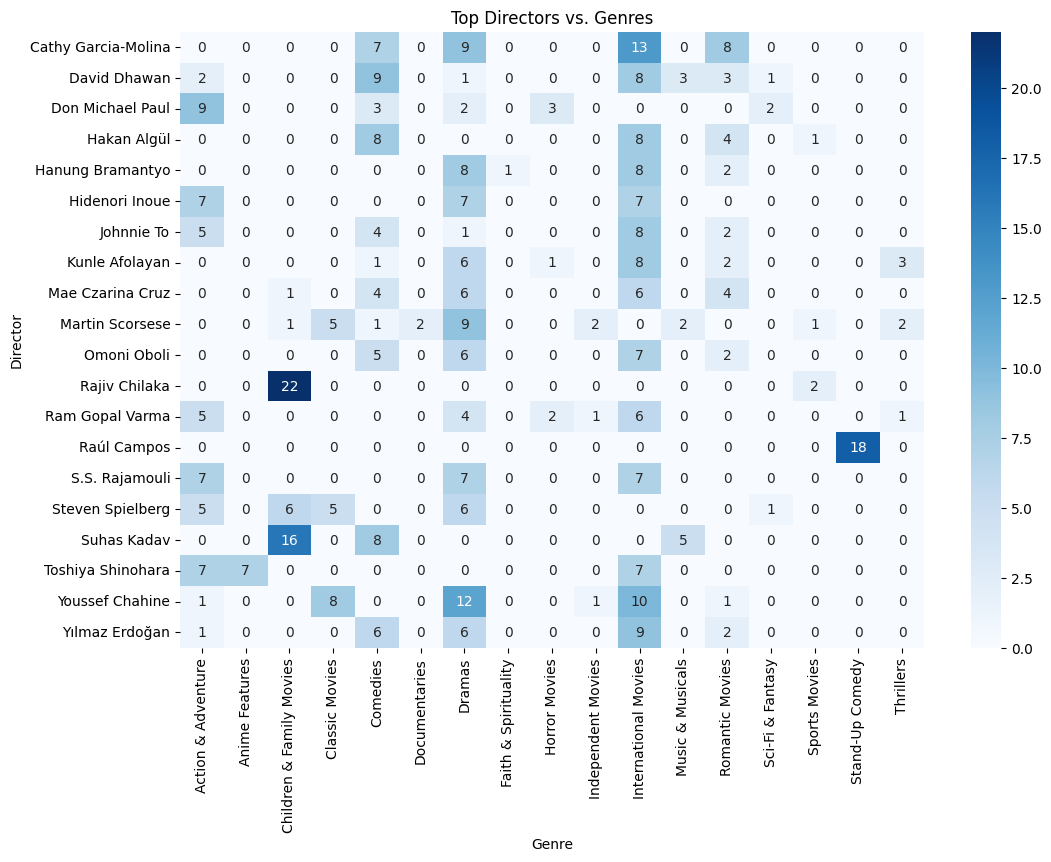

In [18]:
# If 'director' column contains lists, convert it back to strings
df['director'] = df['director'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Split 'listed_in' into lists if not already done
if df['listed_in'].apply(type).eq(list).all():
    # 'listed_in' already contains lists
    pass
else:
    df['listed_in'] = df['listed_in'].str.split(', ')

director_genre_df = df.explode('listed_in')

# Exclude missing or unspecified directors
director_genre_df = director_genre_df[director_genre_df['director'].notnull()]
director_genre_df = director_genre_df[director_genre_df['director'] != 'Not Specified']

# Get top 10 directors
top_directors = director_genre_df['director'].value_counts().head(20).index

# Filter DataFrame for top directors
top_director_genre = director_genre_df[director_genre_df['director'].isin(top_directors)]

# Cross-tabulation between directors and genres
director_genre_ct = pd.crosstab(top_director_genre['director'], top_director_genre['listed_in'])

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(director_genre_ct, annot=True, fmt='d', cmap='Blues')
plt.title('Top Directors vs. Genres')
plt.xlabel('Genre')
plt.ylabel('Director')
plt.show()



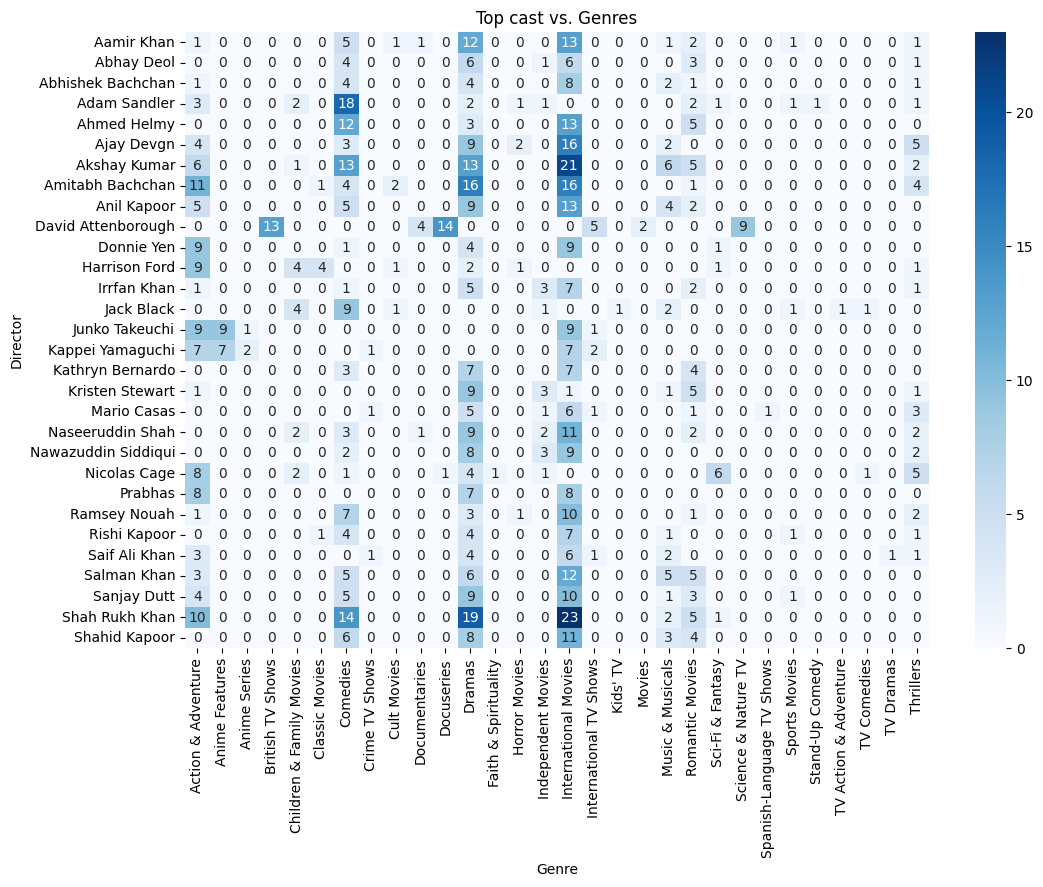

In [19]:
# If 'director' column contains lists, convert it back to strings
df['cast'] = df['cast'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Split 'listed_in' into lists if not already done
if df['listed_in'].apply(type).eq(list).all():
    # 'listed_in' already contains lists
    pass
else:
    df['listed_in'] = df['listed_in'].str.split(', ')

director_genre_df = df.explode('listed_in')

# Exclude missing or unspecified directors
director_genre_df = director_genre_df[director_genre_df['cast'].notnull()]
director_genre_df = director_genre_df[director_genre_df['cast'] != 'Not Specified']

# Get top 10 directors
top_directors = director_genre_df['cast'].value_counts().head(30).index

# Filter DataFrame for top directors
top_director_genre = director_genre_df[director_genre_df['cast'].isin(top_directors)]

# Cross-tabulation between directors and genres
director_genre_ct = pd.crosstab(top_director_genre['cast'], top_director_genre['listed_in'])

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(director_genre_ct, annot=True, fmt='d', cmap='Blues')
plt.title('Top cast vs. Genres')
plt.xlabel('Genre')
plt.ylabel('Director')
plt.show()



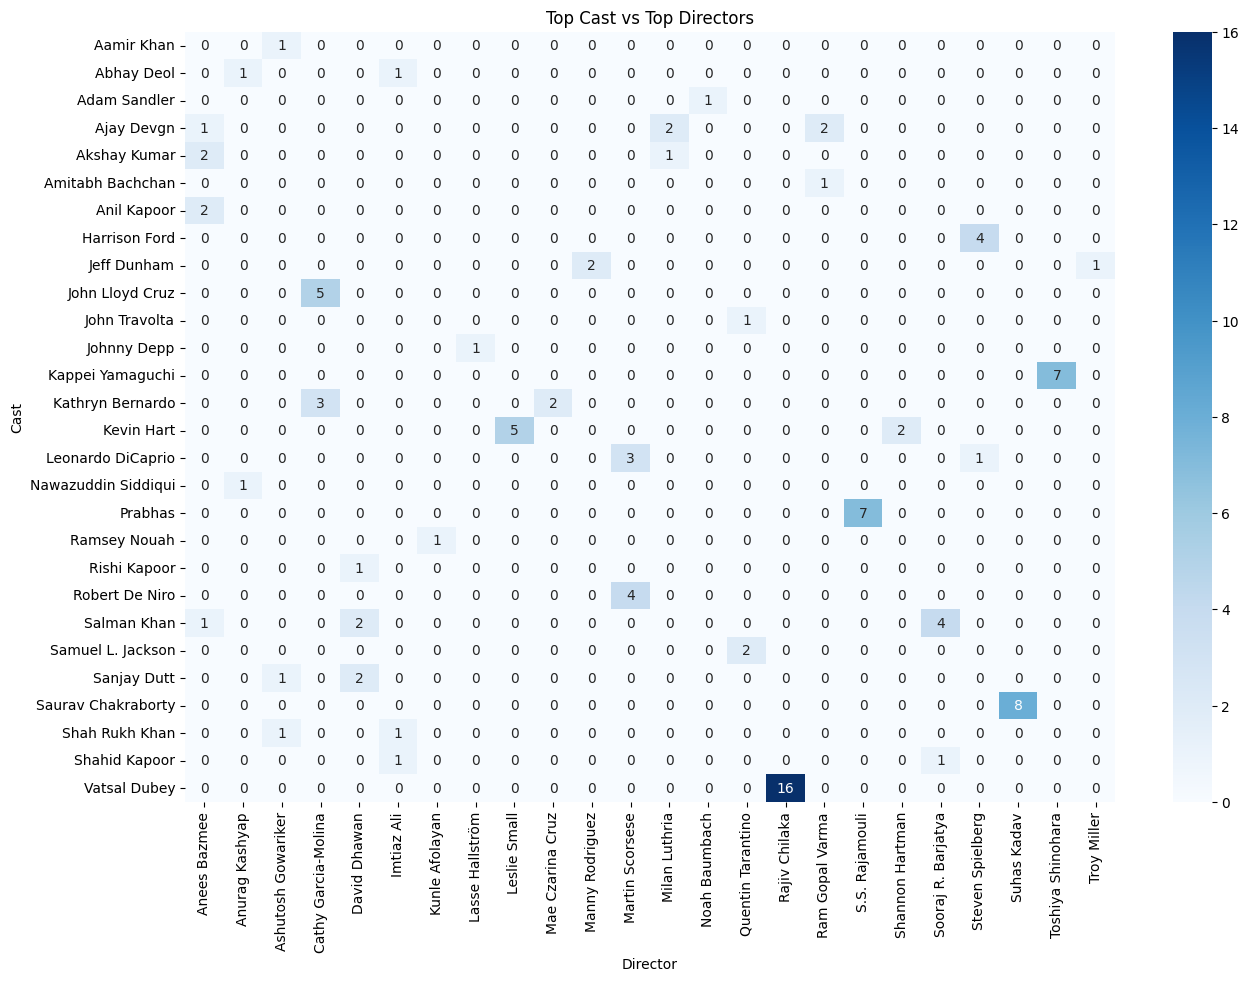

In [20]:
# Ensure 'cast' and 'director' columns are strings and handle missing values
df['cast'] = df['cast'].fillna('Not Specified')
df['director'] = df['director'].fillna('Not Specified')

# Convert 'cast' to lists if not already done
if not df['cast'].apply(lambda x: isinstance(x, list)).all():
    df['cast'] = df['cast'].str.split(', ')

# Explode 'cast' to have one actor per row
cast_director_df = df.explode('cast')

# Filter out entries with 'Not Specified' or missing cast/director
cast_director_df = cast_director_df[
    (cast_director_df['cast'] != 'Not Specified') & (cast_director_df['cast'] != 'nan') &
    (cast_director_df['director'] != 'Not Specified') & (cast_director_df['director'] != 'nan')
]

# Get top N actors and directors
top_cast = cast_director_df['cast'].value_counts().head(50).index
top_directors = cast_director_df['director'].value_counts().head(50).index

# Filter DataFrame for top actors and top directors
top_cast_director_df = cast_director_df[
    (cast_director_df['cast'].isin(top_cast)) &
    (cast_director_df['director'].isin(top_directors))
]

# Cross-tabulation between cast and directors
cast_director_ct = pd.crosstab(top_cast_director_df['cast'], top_cast_director_df['director'])

# Plot the heatmap
plt.figure(figsize=(15,10))
sns.heatmap(cast_director_ct, annot=True, fmt='d', cmap='Blues')
plt.title('Top Cast vs Top Directors')
plt.xlabel('Director')
plt.ylabel('Cast')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


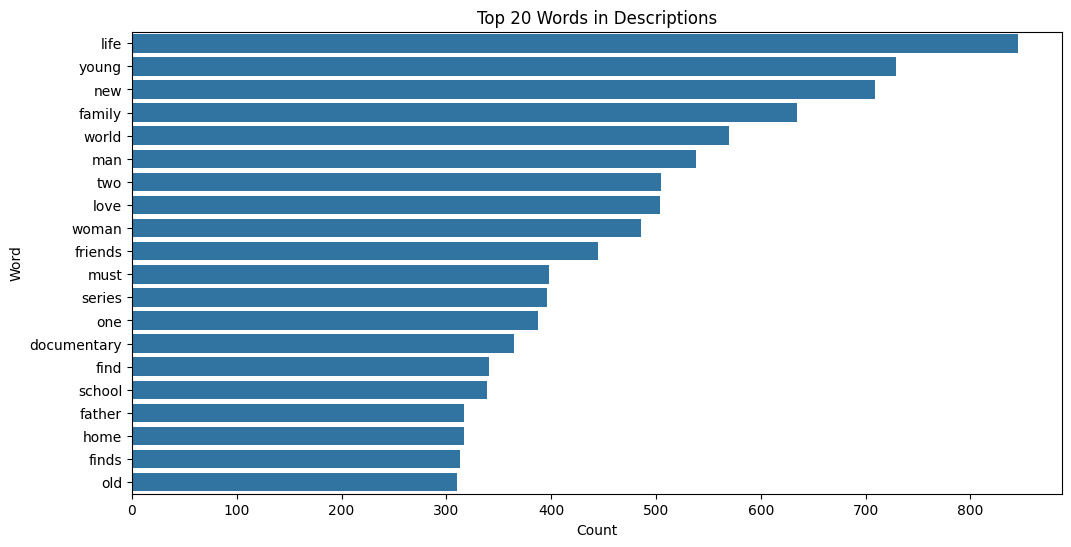

In [21]:
# Combine all descriptions
all_descriptions = ' '.join(df['description'])

# Tokenize and clean text
import re
from collections import Counter

# Remove punctuation and make lowercase
words = re.findall(r'\b\w+\b', all_descriptions.lower())

# Remove stopwords
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Get word frequencies
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)
#print(common_words)

# Bar chart
words_df = pd.DataFrame(common_words, columns=['word', 'count'])
plt.figure(figsize=(12,6))
sns.barplot(x='count', y='word', data=words_df)
plt.title('Top 20 Words in Descriptions')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()
